In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import sys
plt.style.use("dark_background") 
sys.path.append("../src/inference")
from score_models import ScoreModel
from forward_model import complex_to_real, score_likelihood, model
# from posterior_sampling import euler_sampler, complex_to_real, real_to_complex, sigma, mu
# from forward_model import ft, ift, model, score_likelihood, link_function, noise_padding
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
score_model = ScoreModel(checkpoints_directory="/home/noedia/projects/rrg-lplevass/data/score_models/ncsnpp_probes_g_64_230604024652")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Using the Variance Exploding SDE


In [2]:
samples = score_model.sample(steps = 1000, shape = (4, 1, 64, 64))

Sampling from the prior | t = 0.0 | sigma = 1.0e-03| scale ~ 2.9e-01: 100%|██████████| 1000/1000 [00:42<00:00, 23.64it/s]


### Creating an observation.
We choose an isotropic Gaussian likelihood for a linear forward model of the form and we compute it 
$$
p(y\mid x_0) = \mathcal{N}(y \mid A x_0, \sigma_y^2 \mathbf{I}) \, .
$$
For now, we'll choose an identity matrix for our tests. 
Therefore, an observation is simply created by doing 
$$
y = x + \sigma_y \eta
$$
where $\eta \sim \mathcal{N}(0, \sigma_y^2\mathbf{I})$

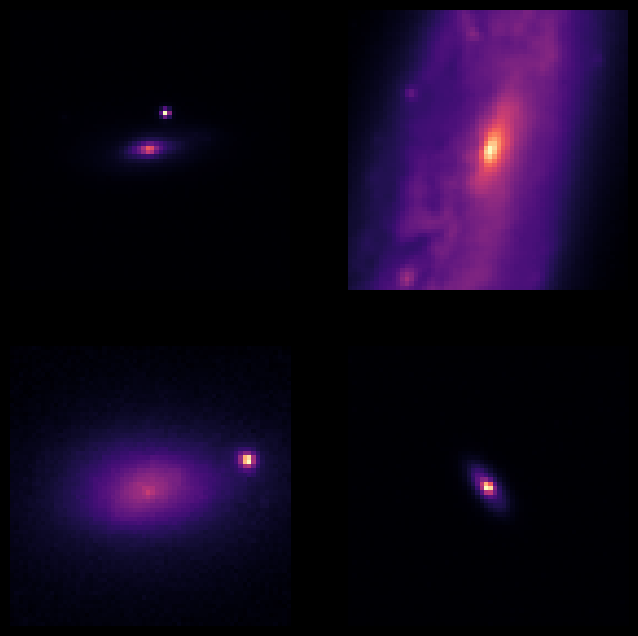

In [3]:
fig, axs = plt.subplots(2, 2, figsize = (4 * 2, 4 * 2))
for i, ax in enumerate(axs.flatten()): 
    ax.imshow(samples[i].squeeze().cpu(), cmap = "magma")
    ax.axis("off") 

In [19]:
def plot(x):
    return x.cpu().squeeze()

def link_function(x):
    return x/2 + 1/2

def forward_model(x):
    return link_function(x)

In [22]:
x = link_function(samples[1])
y_star = forward_model(x)
sigma_y = 1e-2
y = y_star + sigma_y * torch.randn_like(y_star)

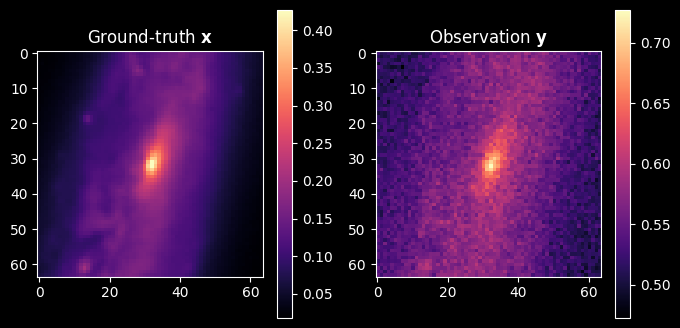

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

im = axs[0].imshow(plot(x), cmap = "magma")
axs[0].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im)
im = axs[1].imshow(plot(y), cmap = "magma") 
axs[1].set_title(r"Observation $\mathbf{y}$")
plt.colorbar(im)

Nice ! Now we construct the likelihood using the convolved likelihod approximation 